<a href="https://colab.research.google.com/github/Resia05/supervised-learning/blob/main/%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# всі імпорти

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore, randint
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score, mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
import joblib
import warnings
import xgboost as xgb
import lightgbm as lgb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# читання даних, розбиття, нормалізація, стандартизація

In [2]:
# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = ['Exited']
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Об'єднання числових, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df, val_categorical_df, val_labels_df], axis=1)

#train_processed_df val_processed_df  train_y  val_y

# перевірка чи дані існують

In [ ]:
display(train_processed_df[:5], val_processed_df[:5])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,...,Surname_Zaytseva,Surname_Zetticci,Surname_Zhirov,Surname_Zikoranachidimma,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Gender_Male
0,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,...,Surname_Zaytseva,Surname_Zetticci,Surname_Zhirov,Surname_Zikoranachidimma,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Gender_Male
0,0.675418,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.386635,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.715990,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.577566,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.589499,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# БАЗОВЕ навчання логістичної регресії 0,88

In [3]:
# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba = model.predict_proba(X_train)[:, 1]
val_preds_proba = model.predict_proba(X_val)[:, 1]
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# Обчислення ROC-AUC
roc_auc_train = roc_auc_score(y_train, train_preds_proba)
roc_auc_val = roc_auc_score(y_val, val_preds_proba)

print(f"ROC-AUC на тренувальних даних: {roc_auc_train:.2f}")
print(f"ROC-AUC на валідаційних даних: {roc_auc_val:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC-AUC на тренувальних даних: 0.90
ROC-AUC на валідаційних даних: 0.88


# КОРЕЛЯЦІЯ та важливість ознак

Список колонок у raw_df: ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Кореляційна матриця на початкових даних (з цільовою змінною):
                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.015715  0.005849 -0.003938       0.020616   
Age                -0.015715  1.000000 -0.013280  0.077270      -0.144124   
Tenure              0.005849 -0.013280  1.000000 -0.023745       0.006091   
Balance            -0.003938  0.077270 -0.023745  1.000000      -0.431749   
NumOfProducts       0.020616 -0.144124  0.006091 -0.431749       1.000000   
HasCrCard          -0.000624 -0.001331  0.022003 -0.010490       0.012605   
IsActiveMember     -0.003239 -0.027171 -0.018856 -0.013445       0.038232   
EstimatedSalary     0.001815  0.000814  0.007302  0.001330      -0.010132   
Exited             -0.047703  0.464689 -0.011637  0

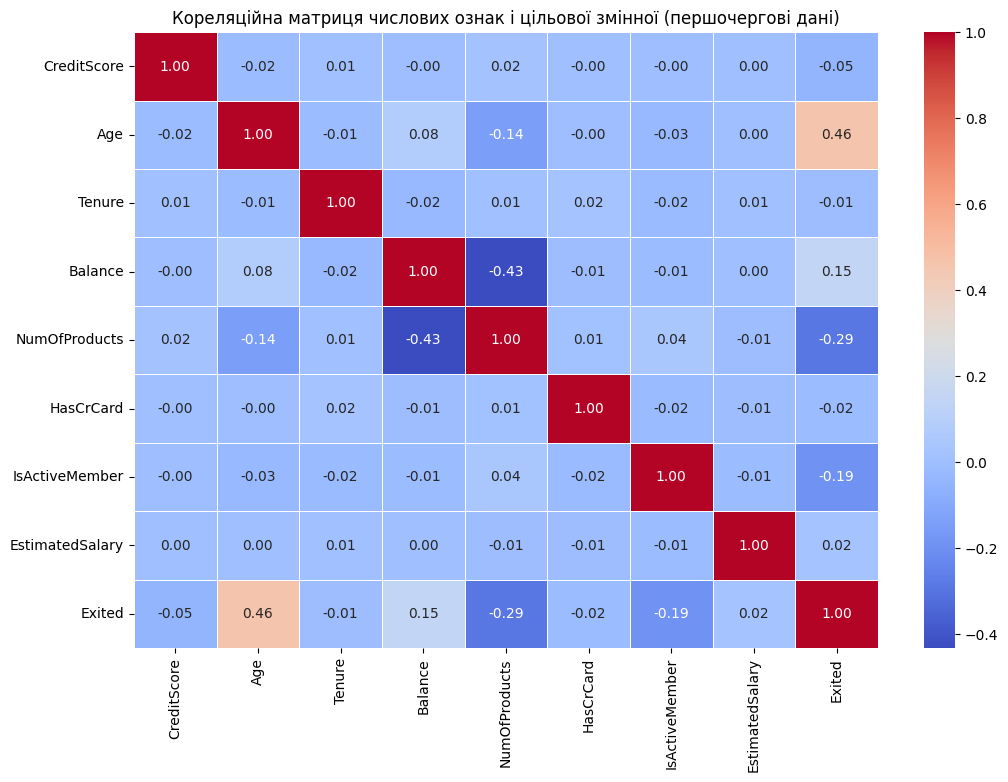

In [ ]:
# Перевірка, чи всі колонки є в raw_df
print("Список колонок у raw_df:", raw_df.columns.tolist())

# Вибір числових ознак і цільової змінної
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
target_col = 'Exited'

# Перевірка наявності всіх колонок
for col in numeric_cols + [target_col]:
    if col not in raw_df.columns:
        raise ValueError(f"Колонка {col} не знайдена в raw_df")

# Обчислення кореляційної матриці на початкових даних, включаючи цільову змінну
correlation_matrix_raw = raw_df[numeric_cols + [target_col]].corr()

# Виведення кореляційної матриці
print("Кореляційна матриця на початкових даних (з цільовою змінною):")
print(correlation_matrix_raw)

# Побудова теплової карти для кореляційної матриці
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_raw, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Кореляційна матриця числових ознак і цільової змінної (першочергові дані)')
plt.show()

In [ ]:
# Отримання коефіцієнтів моделі
coefficients = model.coef_[0]

# Отримання імен ознак
feature_names = np.concatenate([
    X_train.columns
])

# Створення DataFrame з коефіцієнтами
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Сортування ознак за абсолютною величиною коефіцієнтів
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Виведення топ-20 ознак
top_features = importance_df.head(20)
print("Топ-20 ознак за важливістю:")
print(top_features)


Топ-20 ознак за важливістю:
                Feature  Coefficient  Abs_Coefficient
1                   Age     8.537804         8.537804
4         NumOfProducts    -3.867804         3.867804
427    Surname_McIntyre     2.355444         2.355444
425    Surname_McGregor     1.777571         1.777571
474    Surname_Nnaemeka     1.735013         1.735013
322   Surname_Johnstone     1.635816         1.635816
621       Surname_Scott    -1.533966         1.533966
466         Surname_Niu     1.464706         1.464706
617      Surname_Sagese     1.421086         1.421086
254    Surname_Genovesi     1.380542         1.380542
679     Surname_Udobata     1.346921         1.346921
699       Surname_White    -1.336963         1.336963
48       Surname_Bitter     1.298096         1.298096
6        IsActiveMember    -1.273925         1.273925
145         Surname_Chu    -1.250639         1.250639
531  Surname_Olisaemeka     1.246416         1.246416
190     Surname_Dickson    -1.219190         1.219190


<ipython-input-7-f0eb24afc544>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')


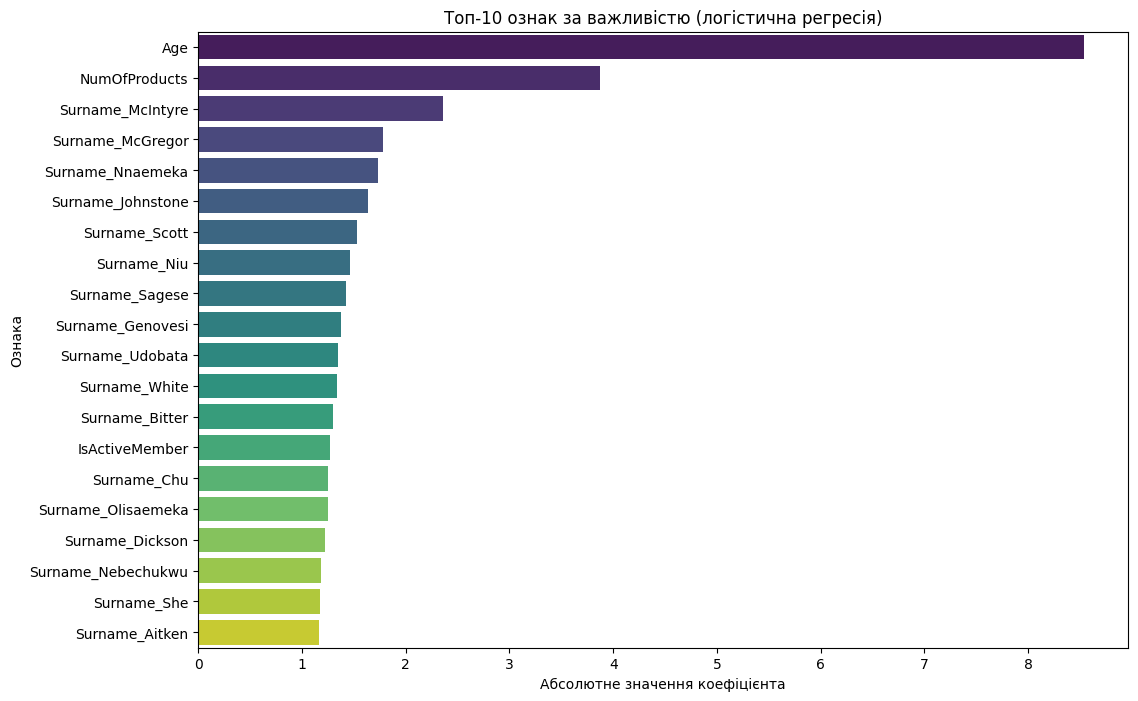

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Візуалізація топ-10 ознак
plt.figure(figsize=(12, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Топ-10 ознак за важливістю (логістична регресія)')
plt.xlabel('Абсолютне значення коефіцієнта')
plt.ylabel('Ознака')
plt.show()


# Пошук гіперпараметрів GridSearchCV для логіст регресії

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Найкращі параметри: {best_params}")

best_model = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Найкращі параметри: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Використання найкращих параметрів для тренування логістичної регресії
best_model = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba = best_model.predict_proba(X_train)[:, 1]
val_preds_proba = best_model.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train = roc_auc_score(y_train, train_preds_proba)
roc_auc_val = roc_auc_score(y_val, val_preds_proba)

print(f"ROC-AUC на тренувальних даних: {roc_auc_train:.2f}")
print(f"ROC-AUC на валідаційних даних: {roc_auc_val:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC-AUC на тренувальних даних: 0.90
ROC-AUC на валідаційних даних: 0.89


# Поліноміальні ознаки для логістичної регресії

In [2]:
# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = ['Exited']
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Створення поліноміальних ознак для числових колонок
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
train_numeric_poly = poly.fit_transform(train_inputs[numeric_cols])
val_numeric_poly = poly.transform(val_inputs[numeric_cols])

# Назви нових колонок
poly_feature_names = poly.get_feature_names_out(numeric_cols)

# Створення DataFrame з поліноміальними ознаками
train_numeric_poly_df = pd.DataFrame(train_numeric_poly, columns=poly_feature_names)
val_numeric_poly_df = pd.DataFrame(val_numeric_poly, columns=poly_feature_names)

# Об'єднання поліноміальних ознак з іншими числовими даними
train_inputs_poly = pd.concat([train_numeric_poly_df, train_inputs.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)
val_inputs_poly = pd.concat([val_numeric_poly_df, val_inputs.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs_poly[poly_feature_names])
val_numeric = numeric_transformer.transform(val_inputs_poly[poly_feature_names])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs_poly[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs_poly[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs_poly[label_cols])
val_labels = label_transformer.transform(val_inputs_poly[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=poly_feature_names)
val_numeric_df = pd.DataFrame(val_numeric, columns=poly_feature_names)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Об'єднання числових, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_poly = best_model_poly.predict_proba(X_train)[:, 1]
val_preds_proba_poly = best_model_poly.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_poly = roc_auc_score(y_train, train_preds_proba_poly)
roc_auc_val_poly = roc_auc_score(y_val, val_preds_proba_poly)

print(f"ROC-AUC на тренувальних даних з поліноміальними ознаками: {roc_auc_train_poly:.2f}")
print(f"ROC-AUC на валідаційних даних з поліноміальними ознаками: {roc_auc_val_poly:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC-AUC на тренувальних даних з поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з поліноміальними ознаками: 0.93


In [4]:
# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = ['Exited']
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Створення поліноміальних ознак для числових колонок
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_numeric_poly = poly.fit_transform(train_inputs[numeric_cols])
val_numeric_poly = poly.transform(val_inputs[numeric_cols])

# Назви нових колонок
poly_feature_names = poly.get_feature_names_out(numeric_cols)

# Створення DataFrame з поліноміальними ознаками
train_numeric_poly_df = pd.DataFrame(train_numeric_poly, columns=poly_feature_names)
val_numeric_poly_df = pd.DataFrame(val_numeric_poly, columns=poly_feature_names)

# Об'єднання поліноміальних ознак з іншими числовими даними
train_inputs_poly = pd.concat([train_numeric_poly_df, train_inputs.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)
val_inputs_poly = pd.concat([val_numeric_poly_df, val_inputs.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs_poly[poly_feature_names])
val_numeric = numeric_transformer.transform(val_inputs_poly[poly_feature_names])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs_poly[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs_poly[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs_poly[label_cols])
val_labels = label_transformer.transform(val_inputs_poly[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=poly_feature_names)
val_numeric_df = pd.DataFrame(val_numeric, columns=poly_feature_names)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Об'єднання числових, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_poly = best_model_poly.predict_proba(X_train)[:, 1]
val_preds_proba_poly = best_model_poly.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_poly = roc_auc_score(y_train, train_preds_proba_poly)
roc_auc_val_poly = roc_auc_score(y_val, val_preds_proba_poly)

print(f"ROC-AUC на тренувальних даних з поліноміальними ознаками: {roc_auc_train_poly:.2f}")
print(f"ROC-AUC на валідаційних даних з поліноміальними ознаками: {roc_auc_val_poly:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC-AUC на тренувальних даних з поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з поліноміальними ознаками: 0.94


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_10_correlated_features = correlation_with_target.index[1:11].tolist()  # Вибираємо топ-10 ознак
top_5_correlated_features = correlation_with_target.index[1:6].tolist()  # Вибираємо топ-5 ознак

print("Топ-10 корельованих ознак з цільовою змінною:", top_10_correlated_features)
print("Топ-5 корельованих ознак з цільовою змінною:", top_5_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-10 корельованих ознак
poly_10 = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly_10 = poly_10.fit_transform(train_numeric_df[top_10_correlated_features])
val_poly_10 = poly_10.transform(val_numeric_df[top_10_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-10
poly_10_columns = poly_10.get_feature_names_out(top_10_correlated_features)
train_poly_10_df = pd.DataFrame(train_poly_10, columns=poly_10_columns)
val_poly_10_df = pd.DataFrame(val_poly_10, columns=poly_10_columns)

# Створення поліноміальних ознак для топ-5 корельованих ознак
poly_5 = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly_5 = poly_5.fit_transform(train_numeric_df[top_5_correlated_features])
val_poly_5 = poly_5.transform(val_numeric_df[top_5_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-5
poly_5_columns = poly_5.get_feature_names_out(top_5_correlated_features)
train_poly_5_df = pd.DataFrame(train_poly_5, columns=poly_5_columns)
val_poly_5_df = pd.DataFrame(val_poly_5, columns=poly_5_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame для топ-10
train_processed_10_df = pd.concat([train_numeric_df.drop(columns=top_10_correlated_features), train_poly_10_df, train_categorical_df, train_labels_df], axis=1)
val_processed_10_df = pd.concat([val_numeric_df.drop(columns=top_10_correlated_features), val_poly_10_df, val_categorical_df, val_labels_df], axis=1)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame для топ-5
train_processed_5_df = pd.concat([train_numeric_df.drop(columns=top_5_correlated_features), train_poly_5_df, train_categorical_df, train_labels_df], axis=1)
val_processed_5_df = pd.concat([val_numeric_df.drop(columns=top_5_correlated_features), val_poly_5_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів для топ-10
X_train_10 = train_processed_10_df
X_val_10 = val_processed_10_df
y_train = train_targets
y_val = val_targets

# Створення X і y для тренувальних і валідаційних наборів для топ-5
X_train_5 = train_processed_5_df
X_val_5 = val_processed_5_df

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками для топ-10
best_model_poly_10 = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly_10.fit(X_train_10, y_train)

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками для топ-5
best_model_poly_5 = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly_5.fit(X_train_5, y_train)

# Прогнозування на тренувальних і валідаційних даних для топ-10
train_preds_proba_poly_10 = best_model_poly_10.predict_proba(X_train_10)[:, 1]
val_preds_proba_poly_10 = best_model_poly_10.predict_proba(X_val_10)[:, 1]

# Прогнозування на тренувальних і валідаційних даних для топ-5
train_preds_proba_poly_5 = best_model_poly_5.predict_proba(X_train_5)[:, 1]
val_preds_proba_poly_5 = best_model_poly_5.predict_proba(X_val_5)[:, 1]

# Обчислення ROC-AUC для топ-10
roc_auc_train_poly_10 = roc_auc_score(y_train, train_preds_proba_poly_10)
roc_auc_val_poly_10 = roc_auc_score(y_val, val_preds_proba_poly_10)

# Обчислення ROC-AUC для топ-5
roc_auc_train_poly_5 = roc_auc_score(y_train, train_preds_proba_poly_5)
roc_auc_val_poly_5 = roc_auc_score(y_val, val_preds_proba_poly_5)

print(f"ROC-AUC на тренувальних даних з топ-10 поліноміальними ознаками: {roc_auc_train_poly_10:.2f}")
print(f"ROC-AUC на валідаційних даних з топ-10 поліноміальними ознаками: {roc_auc_val_poly_10:.2f}")

print(f"ROC-AUC на тренувальних даних з топ-5 поліноміальними ознаками: {roc_auc_train_poly_5:.2f}")
print(f"ROC-AUC на валідаційних даних з топ-5 поліноміальними ознаками: {roc_auc_val_poly_5:.2f}")


Топ-10 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore', 'HasCrCard', 'EstimatedSalary', 'Tenure']
Топ-5 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore']
ROC-AUC на тренувальних даних з топ-10 поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з топ-10 поліноміальними ознаками: 0.94
ROC-AUC на тренувальних даних з топ-5 поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з топ-5 поліноміальними ознаками: 0.94


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_3_correlated_features = correlation_with_target.index[1:4].tolist()  # Вибираємо топ-3 ознаки

print("Топ-3 корельованих ознак з цільовою змінною:", top_3_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-3 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_3_correlated_features])
val_poly = poly.transform(val_numeric_df[top_3_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-3
poly_columns = poly.get_feature_names_out(top_3_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_3_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_3_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_poly = best_model_poly.predict_proba(X_train)[:, 1]
val_preds_proba_poly = best_model_poly.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_poly = roc_auc_score(y_train, train_preds_proba_poly)
roc_auc_val_poly = roc_auc_score(y_val, val_preds_proba_poly)

print(f"ROC-AUC на тренувальних даних з поліноміальними ознаками: {roc_auc_train_poly:.2f}")
print(f"ROC-AUC на валідаційних даних з поліноміальними ознаками: {roc_auc_val_poly:.2f}")


Топ-3 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember']
ROC-AUC на тренувальних даних з поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з поліноміальними ознаками: 0.94


# Кінцевий варіант по логістичній регресії

In [3]:
# на кагл 0,93 (((

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Читання даних з файлів
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)
test_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/test.csv")
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/sample_submission.csv")

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_3_correlated_features = correlation_with_target.index[1:4].tolist()  # Вибираємо топ-3 ознаки

print("Топ-3 корельованих ознак з цільовою змінною:", top_3_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])
test_numeric = numeric_transformer.transform(test_raw_df[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])
test_categorical = categorical_transformer.transform(test_raw_df[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])
test_labels = label_transformer.transform(test_raw_df[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)
test_numeric_df = pd.DataFrame(test_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)
test_categorical_df = pd.DataFrame(test_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)
test_labels_df = pd.DataFrame(test_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-3 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_3_correlated_features])
val_poly = poly.transform(val_numeric_df[top_3_correlated_features])
test_poly = poly.transform(test_numeric_df[top_3_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-3
poly_columns = poly.get_feature_names_out(top_3_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)
test_poly_df = pd.DataFrame(test_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_3_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_3_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)
test_processed_df = pd.concat([test_numeric_df.drop(columns=top_3_correlated_features), test_poly_df, test_categorical_df, test_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_poly = best_model_poly.predict_proba(X_train)[:, 1]
val_preds_proba_poly = best_model_poly.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_poly = roc_auc_score(y_train, train_preds_proba_poly)
roc_auc_val_poly = roc_auc_score(y_val, val_preds_proba_poly)

print(f"ROC-AUC на тренувальних даних з поліноміальними ознаками: {roc_auc_train_poly:.2f}")
print(f"ROC-AUC на валідаційних даних з поліноміальними ознаками: {roc_auc_val_poly:.2f}")

# Прогнозування на тестових даних
test_inputs = test_raw_df[input_cols]
test_numeric = numeric_transformer.transform(test_inputs[numeric_cols])
test_categorical = categorical_transformer.transform(test_inputs[categorical_cols])
test_labels = label_transformer.transform(test_inputs[label_cols])
test_poly = poly.transform(test_numeric_df[top_3_correlated_features])

# Об'єднання оброблених тестових даних
test_processed_df = pd.concat([
    pd.DataFrame(test_numeric, columns=numeric_cols).drop(columns=top_3_correlated_features),
    pd.DataFrame(test_poly, columns=poly_columns),
    pd.DataFrame(test_categorical, columns=categorical_columns),
    pd.DataFrame(test_labels, columns=label_columns)
], axis=1)

# Прогнозування ймовірностей для тестових даних
proba = best_model_poly.predict_proba(test_processed_df)[:, 1]
test_raw_df['Exited_Probability'] = proba

# Запис результатів у файл подання
sample_submission_df['Exited'] = test_raw_df['Exited_Probability']
sample_submission_df.to_csv('submission_log_reg_2007_1.csv', index=False)
print("Файл з поданням створено: submission_log_reg_2007_1.csv")


Топ-3 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember']
ROC-AUC на тренувальних даних з поліноміальними ознаками: 0.94
ROC-AUC на валідаційних даних з поліноміальними ознаками: 0.94
Файл з поданням створено: submission_log_reg_2007_1.csv


# Балансування для логістичної

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_3_correlated_features = correlation_with_target.index[1:4].tolist()  # Вибираємо топ-3 ознаки

print("Топ-3 корельованих ознак з цільовою змінною:", top_3_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-3 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_3_correlated_features])
val_poly = poly.transform(val_numeric_df[top_3_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-3
poly_columns = poly.get_feature_names_out(top_3_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_3_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_3_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація SMOTE і Edited Nearest Neighbors
smote = SMOTE(random_state=42)
enn = EditedNearestNeighbours()

# Створення пайплайну для SMOTE + Edited Nearest Neighbours
resampling_pipeline = Pipeline([
    ('smote', smote),
    ('enn', enn)
])

# Балансування даних
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

# Ініціалізація і тренування моделі логістичної регресії з поліноміальними ознаками
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train_resampled, y_train_resampled)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_poly = best_model_poly.predict_proba(X_train_resampled)[:, 1]
val_preds_proba_poly = best_model_poly.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_poly = roc_auc_score(y_train_resampled, train_preds_proba_poly)
roc_auc_val_poly = roc_auc_score(y_val, val_preds_proba_poly)

print(f"ROC-AUC на тренувальних даних з поліноміальними ознаками та балансуванням: {roc_auc_train_poly:.2f}")
print(f"ROC-AUC на валідаційних даних з поліноміальними ознаками та балансуванням: {roc_auc_val_poly:.2f}")


Топ-3 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember']
ROC-AUC на тренувальних даних з поліноміальними ознаками та балансуванням: 0.96
ROC-AUC на валідаційних даних з поліноміальними ознаками та балансуванням: 0.93


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.1, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_5_correlated_features = correlation_with_target.index[1:6].tolist()  # Вибираємо топ-5 ознак

print("Топ-5 корельованих ознак з цільовою змінною:", top_5_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-5 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_5_correlated_features])
val_poly = poly.transform(val_numeric_df[top_5_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-5
poly_columns = poly.get_feature_names_out(top_5_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_5_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_5_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Балансування даних
smote_enn = SMOTEENN()
X_train_bal, y_train_bal = smote_enn.fit_resample(train_processed_df, train_targets)

# Ініціалізація і тренування моделі логістичної регресії
model_smoteenn = LogisticRegression(solver='liblinear', C=1, penalty='l1')
model_smoteenn.fit(X_train_bal, y_train_bal)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_smoteenn = model_smoteenn.predict_proba(X_train_bal)[:, 1]
val_preds_proba_smoteenn = model_smoteenn.predict_proba(val_processed_df)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_smoteenn = roc_auc_score(y_train_bal, train_preds_proba_smoteenn)
roc_auc_val_smoteenn = roc_auc_score(val_targets, val_preds_proba_smoteenn)

print(f"ROC-AUC на тренувальних даних з SMOTEENN: {roc_auc_train_smoteenn:.2f}")
print(f"ROC-AUC на валідаційних даних з SMOTEENN: {roc_auc_val_smoteenn:.2f}")


Топ-5 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore']
ROC-AUC на тренувальних даних з SMOTEENN: 0.99
ROC-AUC на валідаційних даних з SMOTEENN: 0.91


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_3_correlated_features = correlation_with_target.index[1:4].tolist()  # Вибираємо топ-3 ознаки

print("Топ-3 корельованих ознак з цільовою змінною:", top_3_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-3 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_3_correlated_features])
val_poly = poly.transform(val_numeric_df[top_3_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-3
poly_columns = poly.get_feature_names_out(top_3_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_3_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_3_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація моделі логістичної регресії з вагою класів
class_weights = {0: 1, 1: 5}  # Наприклад, можна задати вагу 5 для меншого класу
model_with_weights = LogisticRegression(solver='liblinear', C=1, penalty='l1', class_weight=class_weights)
model_with_weights.fit(X_train, y_train)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_with_weights = model_with_weights.predict_proba(X_train)[:, 1]
val_preds_proba_with_weights = model_with_weights.predict_proba(X_val)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_with_weights = roc_auc_score(y_train, train_preds_proba_with_weights)
roc_auc_val_with_weights = roc_auc_score(y_val, val_preds_proba_with_weights)

print(f"ROC-AUC на тренувальних даних з вагою класів: {roc_auc_train_with_weights:.2f}")
print(f"ROC-AUC на валідаційних даних з вагою класів: {roc_auc_val_with_weights:.2f}")




Топ-3 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember']
ROC-AUC на тренувальних даних з вагою класів: 0.95
ROC-AUC на валідаційних даних з вагою класів: 0.93


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_5_correlated_features = correlation_with_target.index[1:6].tolist()  # Вибираємо топ-5 ознак

print("Топ-5 корельованих ознак з цільовою змінною:", top_5_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-5 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_5_correlated_features])
val_poly = poly.transform(val_numeric_df[top_5_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-5
poly_columns = poly.get_feature_names_out(top_5_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_5_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_5_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Ініціалізація моделі логістичної регресії з вагою класів
class_weights = {0: 1, 1: 5}  # Наприклад, можна задати вагу 5 для меншого класу
model_with_weights = LogisticRegression(solver='liblinear', C=1, penalty='l1', class_weight=class_weights)
model_with_weights.fit(train_processed_df, train_targets)

# Прогнозування на тренувальних і валідаційних даних
train_preds_proba_with_weights = model_with_weights.predict_proba(train_processed_df)[:, 1]
val_preds_proba_with_weights = model_with_weights.predict_proba(val_processed_df)[:, 1]

# Обчислення ROC-AUC
roc_auc_train_with_weights = roc_auc_score(train_targets, train_preds_proba_with_weights)
roc_auc_val_with_weights = roc_auc_score(val_targets, val_preds_proba_with_weights)

print(f"ROC-AUC на тренувальних даних з вагою класів: {roc_auc_train_with_weights:.2f}")
print(f"ROC-AUC на валідаційних даних з вагою класів: {roc_auc_val_with_weights:.2f}")


Топ-5 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore']
ROC-AUC на тренувальних даних з вагою класів: 0.95
ROC-AUC на валідаційних даних з вагою класів: 0.94


# Крос валідація + поліноміальні + пошук параметрів + зміщення вагів + балансування 0,935

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_5_correlated_features = correlation_with_target.index[1:6].tolist()  # Вибираємо топ-5 ознак

print("Топ-5 корельованих ознак з цільовою змінною:", top_5_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-5 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_5_correlated_features])
val_poly = poly.transform(val_numeric_df[top_5_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-5
poly_columns = poly.get_feature_names_out(top_5_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_5_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_5_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Крос-валідація
cv_scores = cross_val_score(best_model_poly, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Середній ROC-AUC з крос-валідацією: {cv_scores.mean():.2f}")
print(f"Стандартне відхилення ROC-AUC з крос-валідацією: {cv_scores.std():.2f}")

# Балансування класів

## 1. SMOTE + Edited Nearest Neighbors (SMOTEENN)
smote_enn = SMOTEENN()
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Навчання моделі на збалансованих даних
best_model_resampled = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_resampled.fit(X_train_resampled, y_train_resampled)

# Оцінка моделі
train_preds_proba_resampled = best_model_resampled.predict_proba(X_train_resampled)[:, 1]
val_preds_proba_resampled = best_model_resampled.predict_proba(X_val)[:, 1]

roc_auc_train_resampled = roc_auc_score(y_train_resampled, train_preds_proba_resampled)
roc_auc_val_resampled = roc_auc_score(y_val, val_preds_proba_resampled)

print(f"ROC-AUC на тренувальних даних з балансуванням SMOTEENN: {roc_auc_train_resampled:.2f}")
print(f"ROC-AUC на валідаційних даних з балансуванням SMOTEENN: {roc_auc_val_resampled:.2f}")

## 2. Зміна ваг класів
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

weighted_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', class_weight=class_weights_dict)
weighted_model.fit(X_train, y_train)

# Оцінка моделі
train_preds_proba_weighted = weighted_model.predict_proba(X_train)[:, 1]
val_preds_proba_weighted = weighted_model.predict_proba(X_val)[:, 1]

roc_auc_train_weighted = roc_auc_score(y_train, train_preds_proba_weighted)
roc_auc_val_weighted = roc_auc_score(y_val, val_preds_proba_weighted)

print(f"ROC-AUC на тренувальних даних з зміною ваг класів: {roc_auc_train_weighted:.2f}")
print(f"ROC-AUC на валідаційних даних з зміною ваг класів: {roc_auc_val_weighted:.2f}")

# Прогнозування на тестових даних
test_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/test.csv")
test_inputs = test_raw_df[input_cols]
test_numeric = numeric_transformer.transform(test_inputs[numeric_cols])
test_categorical = categorical_transformer.transform(test_inputs[categorical_cols])
test_labels = label_transformer.transform(test_inputs[label_cols])

test_numeric_df = pd.DataFrame(test_numeric, columns=numeric_cols)
test_categorical_df = pd.DataFrame(test_categorical, columns=categorical_columns)
test_labels_df = pd.DataFrame(test_labels, columns=label_columns)

test_poly = poly.transform(test_numeric_df[top_5_correlated_features])
test_poly_df = pd.DataFrame(test_poly, columns=poly_columns)

test_processed_df = pd.concat([test_numeric_df.drop(columns=top_5_correlated_features), test_poly_df, test_categorical_df, test_labels_df], axis=1)

# Прогнозування з найбільшою ROC-AUC
proba = weighted_model.predict_proba(test_processed_df)[:, 1]
test_raw_df['Exited_Probability'] = proba
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/sample_submission.csv")
sample_submission_df['Exited'] = test_raw_df['Exited_Probability']
sample_submission_df.to_csv('submission_log_reg_2007_2.csv', index=False)
sample_submission_df


Топ-5 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore']
Середній ROC-AUC з крос-валідацією: 0.93
Стандартне відхилення ROC-AUC з крос-валідацією: 0.01
ROC-AUC на тренувальних даних з балансуванням SMOTEENN: 0.99
ROC-AUC на валідаційних даних з балансуванням SMOTEENN: 0.92
ROC-AUC на тренувальних даних з зміною ваг класів: 0.95
ROC-AUC на валідаційних даних з зміною ваг класів: 0.94


,id,Exited
0,15000,0.090899
1,15001,0.062395
2,15002,0.099942
3,15003,0.768270
4,15004,0.077518
...,...,...
9995,24995,0.012825
9996,24996,0.038334
9997,24997,0.011462
9998,24998,0.325455


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight

# Читання даних з файлу
raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv", index_col=0)

# Розбиття на тренувальний і валідаційний набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)

# Визначення колонок
input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography', 'Surname', 'Gender']
target_col = 'Exited'
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography', 'Surname']
label_cols = ['Gender']

# Виділення тренувальних і валідаційних наборів
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Обчислення кореляції з цільовою змінною
correlation_with_target = train_df[numeric_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
top_5_correlated_features = correlation_with_target.index[1:6].tolist()  # Вибираємо топ-5 ознак

print("Топ-5 корельованих ознак з цільовою змінною:", top_5_correlated_features)

# Створення трансформаторів для числових даних
numeric_transformer = MinMaxScaler()
train_numeric = numeric_transformer.fit_transform(train_inputs[numeric_cols])
val_numeric = numeric_transformer.transform(val_inputs[numeric_cols])

# Створення трансформаторів для категоріальних даних
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_categorical = categorical_transformer.fit_transform(train_inputs[categorical_cols])
val_categorical = categorical_transformer.transform(val_inputs[categorical_cols])

# Створення трансформаторів для міток
label_transformer = OneHotEncoder(categories=[['Female', 'Male']], drop='first', sparse_output=False)
train_labels = label_transformer.fit_transform(train_inputs[label_cols])
val_labels = label_transformer.transform(val_inputs[label_cols])

# Створення DataFrame для числових даних
train_numeric_df = pd.DataFrame(train_numeric, columns=numeric_cols)
val_numeric_df = pd.DataFrame(val_numeric, columns=numeric_cols)

# Створення DataFrame для категоріальних даних
categorical_columns = categorical_transformer.get_feature_names_out(categorical_cols)
train_categorical_df = pd.DataFrame(train_categorical, columns=categorical_columns)
val_categorical_df = pd.DataFrame(val_categorical, columns=categorical_columns)

# Створення DataFrame для міток
label_columns = label_transformer.get_feature_names_out(label_cols)
train_labels_df = pd.DataFrame(train_labels, columns=label_columns)
val_labels_df = pd.DataFrame(val_labels, columns=label_columns)

# Створення поліноміальних ознак для топ-5 корельованих ознак
poly = PolynomialFeatures(degree=8, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_numeric_df[top_5_correlated_features])
val_poly = poly.transform(val_numeric_df[top_5_correlated_features])

# Створення DataFrame для поліноміальних ознак топ-5
poly_columns = poly.get_feature_names_out(top_5_correlated_features)
train_poly_df = pd.DataFrame(train_poly, columns=poly_columns)
val_poly_df = pd.DataFrame(val_poly, columns=poly_columns)

# Об'єднання числових, поліноміальних, категоріальних даних і міток в один DataFrame
train_processed_df = pd.concat([train_numeric_df.drop(columns=top_5_correlated_features), train_poly_df, train_categorical_df, train_labels_df], axis=1)
val_processed_df = pd.concat([val_numeric_df.drop(columns=top_5_correlated_features), val_poly_df, val_categorical_df, val_labels_df], axis=1)

# Створення X і y для тренувальних і валідаційних наборів
X_train = train_processed_df
X_val = val_processed_df
y_train = train_targets
y_val = val_targets

# Ініціалізація і тренування моделі логістичної регресії
best_model_poly = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_poly.fit(X_train, y_train)

# Крос-валідація
cv_scores = cross_val_score(best_model_poly, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Середній ROC-AUC з крос-валідацією: {cv_scores.mean():.2f}")
print(f"Стандартне відхилення ROC-AUC з крос-валідацією: {cv_scores.std():.2f}")

# Балансування класів

## 1. SMOTE + Edited Nearest Neighbors (SMOTEENN)
smote_enn = SMOTEENN()
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Навчання моделі на збалансованих даних
best_model_resampled = LogisticRegression(solver='liblinear', C=1, penalty='l1')
best_model_resampled.fit(X_train_resampled, y_train_resampled)

# Оцінка моделі
train_preds_proba_resampled = best_model_resampled.predict_proba(X_train_resampled)[:, 1]
val_preds_proba_resampled = best_model_resampled.predict_proba(X_val)[:, 1]

roc_auc_train_resampled = roc_auc_score(y_train_resampled, train_preds_proba_resampled)
roc_auc_val_resampled = roc_auc_score(y_val, val_preds_proba_resampled)

print(f"ROC-AUC на тренувальних даних з балансуванням SMOTEENN: {roc_auc_train_resampled:.2f}")
print(f"ROC-AUC на валідаційних даних з балансуванням SMOTEENN: {roc_auc_val_resampled:.2f}")

## 2. Зміна ваг класів
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

weighted_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', class_weight=class_weights_dict)
weighted_model.fit(X_train, y_train)

# Оцінка моделі
train_preds_proba_weighted = weighted_model.predict_proba(X_train)[:, 1]
val_preds_proba_weighted = weighted_model.predict_proba(X_val)[:, 1]

roc_auc_train_weighted = roc_auc_score(y_train, train_preds_proba_weighted)
roc_auc_val_weighted = roc_auc_score(y_val, val_preds_proba_weighted)

print(f"ROC-AUC на тренувальних даних з зміною ваг класів: {roc_auc_train_weighted:.2f}")
print(f"ROC-AUC на валідаційних даних з зміною ваг класів: {roc_auc_val_weighted:.2f}")

# Підбір гіперпараметрів

# Визначення параметрів для GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# 1. Для моделі без балансування
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Найкращі параметри без балансування:", grid_search.best_params_)
print(f"Найкращий ROC-AUC без балансування: {grid_search.best_score_:.2f}")

# 2. Для моделі з SMOTEENN
grid_search_resampled = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc')
grid_search_resampled.fit(X_train_resampled, y_train_resampled)

print("Найкращі параметри з балансуванням SMOTEENN:", grid_search_resampled.best_params_)
print(f"Найкращий ROC-AUC з балансуванням SMOTEENN: {grid_search_resampled.best_score_:.2f}")

# 3. Для моделі зі зміною ваг класів
grid_search_weighted = GridSearchCV(LogisticRegression(solver='liblinear', class_weight=class_weights_dict), param_grid, cv=5, scoring='roc_auc')
grid_search_weighted.fit(X_train, y_train)

print("Найкращі параметри з зміною ваг класів:", grid_search_weighted.best_params_)
print(f"Найкращий ROC-AUC з зміною ваг класів: {grid_search_weighted.best_score_:.2f}")

# Прогнозування з найкращими моделями
test_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/test.csv")
test_inputs = test_raw_df[input_cols]
test_numeric = numeric_transformer.transform(test_inputs[numeric_cols])
test_categorical = categorical_transformer.transform(test_inputs[categorical_cols])
test_labels = label_transformer.transform(test_inputs[label_cols])

test_numeric_df = pd.DataFrame(test_numeric, columns=numeric_cols)
test_categorical_df = pd.DataFrame(test_categorical, columns=categorical_columns)
test_labels_df = pd.DataFrame(test_labels, columns=label_columns)

test_poly = poly.transform(test_numeric_df[top_5_correlated_features])
test_poly_df = pd.DataFrame(test_poly, columns=poly_columns)

test_processed_df = pd.concat([test_numeric_df.drop(columns=top_5_correlated_features), test_poly_df, test_categorical_df, test_labels_df], axis=1)

# Прогнозування з найбільшою ROC-AUC
proba = grid_search.best_estimator_.predict_proba(test_processed_df)[:, 1]
test_raw_df['Exited_Probability'] = proba
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/sample_submission.csv")
sample_submission_df['Exited'] = test_raw_df['Exited_Probability']
sample_submission_df.to_csv('submission_log_reg_1706_3.csv', index=False)
sample_submission_df


Топ-5 корельованих ознак з цільовою змінною: ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore']
Середній ROC-AUC з крос-валідацією: 0.93
Стандартне відхилення ROC-AUC з крос-валідацією: 0.01
ROC-AUC на тренувальних даних з балансуванням SMOTEENN: 0.99
ROC-AUC на валідаційних даних з балансуванням SMOTEENN: 0.93
ROC-AUC на тренувальних даних з зміною ваг класів: 0.95
ROC-AUC на валідаційних даних з зміною ваг класів: 0.94
Найкращі параметри без балансування: {'C': 1, 'penalty': 'l1'}
Найкращий ROC-AUC без балансування: 0.93
Найкращі параметри з балансуванням SMOTEENN: {'C': 10, 'penalty': 'l2'}
Найкращий ROC-AUC з балансуванням SMOTEENN: 0.99
Найкращі параметри з зміною ваг класів: {'C': 1, 'penalty': 'l1'}
Найкращий ROC-AUC з зміною ваг класів: 0.93


,id,Exited
0,15000,0.044243
1,15001,0.018860
2,15002,0.028733
3,15003,0.499473
4,15004,0.025189
...,...,...
9995,24995,0.005338
9996,24996,0.010164
9997,24997,0.003927
9998,24998,0.114006


In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Створення та тренування моделі з RFE
model = LogisticRegression(solver='liblinear', class_weight='balanced')
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Вибір важливих ознак
important_features = X_train.columns[selector.support_]
print("Важливі ознаки:", important_features)

# Модель з Elastic Net
from sklearn.linear_model import ElasticNet

elastic_net_model = ElasticNet()
elastic_net_model.fit(X_train, y_train)

# Крос-валідація з StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model_poly, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"Середній ROC-AUC з StratifiedKFold крос-валідацією: {cv_scores.mean():.2f}")
print(f"Стандартне відхилення ROC-AUC з StratifiedKFold крос-валідацією: {cv_scores.std():.2f}")


Важливі ознаки: Index(['Age', 'NumOfProducts', 'Age^2', 'NumOfProducts^2',
       'NumOfProducts Balance', 'NumOfProducts^3', 'NumOfProducts^4',
       'NumOfProducts^5', 'Age^4 IsActiveMember^3', 'Age^4 IsActiveMember^4'],
      dtype='object')
Середній ROC-AUC з StratifiedKFold крос-валідацією: 0.93
Стандартне відхилення ROC-AUC з StratifiedKFold крос-валідацією: 0.01
